In [50]:
from pmdarima import auto_arima
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from arch import arch_model
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
df = pd.read_csv('BitcoinEnergyCambridge.csv')
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Date"] > "2017-01-01"]
df = df.set_index("Date")
df.head()

,Timestamp,MAX GW,MIN GW,GUESS GW,annualised consumption MAX TWh,annualised consumption MIN TWh,annualised consumption GUESS TWh
Date,,,,,,,
2017-01-02,1483315200,1.498434,1.261182,1.373565,13.135274,11.055522,12.040667
2017-01-03,1483401600,1.514614,1.274800,1.388396,13.277109,11.174900,12.170683
2017-01-04,1483488000,1.503239,1.265226,1.377969,13.177394,11.090973,12.079277
2017-01-05,1483574400,1.489409,1.253586,1.365292,13.056162,10.988936,11.968148
2017-01-06,1483660800,1.494941,1.258242,1.370363,13.104653,11.029749,12.012598


<AxesSubplot:xlabel='Date'>

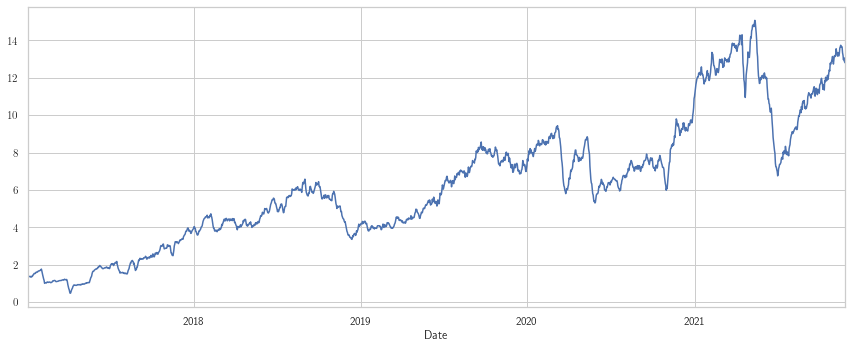

In [53]:
df['GUESS GW'].plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

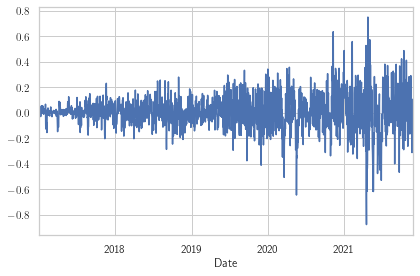

In [54]:
diff = df['GUESS GW'].diff()
diff.plot()

In [55]:
df['diff'] = df['GUESS GW'].diff()
# df = df.reset_index()
df

,Timestamp,MAX GW,MIN GW,GUESS GW,annualised consumption MAX TWh,annualised consumption MIN TWh,annualised consumption GUESS TWh,diff
Date,,,,,,,,
2017-01-02,1483315200,1.498434,1.261182,1.373565,13.135274,11.055522,12.040667,NaN
2017-01-03,1483401600,1.514614,1.274800,1.388396,13.277109,11.174900,12.170683,0.014832
2017-01-04,1483488000,1.503239,1.265226,1.377969,13.177394,11.090973,12.079277,-0.010427
2017-01-05,1483574400,1.489409,1.253586,1.365292,13.056162,10.988936,11.968148,-0.012677
2017-01-06,1483660800,1.494941,1.258242,1.370363,13.104653,11.029749,12.012598,0.005071
...,...,...,...,...,...,...,...,...
2021-11-23,1637625600,48.617960,4.709599,12.969188,426.185037,41.284341,113.687902,-0.238216
2021-11-24,1637712000,49.014837,4.748044,13.075058,429.664059,41.621352,114.615956,0.105870
2021-11-25,1637798400,48.320291,4.680764,12.889783,423.575674,41.031573,112.991836,-0.185275


In [56]:
sns.set(font_scale=1, rc={'text.usetex': True})
sns.set_style("whitegrid")

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rcParams['axes.titlesize'] = 20

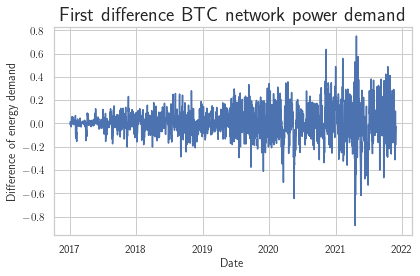

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.lineplot(x="Date", y="diff", data=df)
# plt.xticks(rotation=15)
plt.title('First difference BTC network power demand')
ax.set(xlabel='Date', ylabel='Difference of energy demand')
plt.savefig('difference_energy_transparent.png', dpi=400, transparent=True)
plt.show()
plt.close()

In [58]:
# differentiated series is stationary (dickey fuller)
X = diff[1:]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.176451
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [59]:
stepwise_fit = auto_arima(df['GUESS GW'], trace = True,
                          suppress_warnings = True)        
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2057.782, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2171.180, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2144.071, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2055.847, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2206.920, Time=1.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2219.911, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2244.974, Time=0.33 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2248.029, Time=0.44 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-2246.191, Time=2.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2244.957, Time=2.62 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-2249.029, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-2245.851, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-2247.188, Time=1.00 sec
 ARIMA(4,1,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1791
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1130.514
Date:                Sat, 11 Dec 2021   AIC                          -2249.029
Time:                        15:38:55   BIC                          -2216.089
Sample:                             0   HQIC                         -2236.866
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1835      0.015     12.620      0.000       0.155       0.212
ar.L2          0.1067      0.016      6.752      0.000       0.076       0.138
ar.L3          0.0616      0.019      3.260      0.001       0.025       0.099
ar.L4          0.1131      0.017      6.751      0.000       0.080       0.146
ar.L5          0.0539      0.017      3.255      0.001       0.021       0.086
sigma2         0.0166      0.000     49.700      0.000       0.016       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1130.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               7.79   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape, test.shape)

(1791, 8)
(1761, 8) (30, 8)


In [61]:
model=ARIMA(train['GUESS GW'],order=(5,1,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.GUESS GW   No. Observations:                 1760
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1120.211
Method:                       css-mle   S.D. of innovations              0.128
Date:                Sat, 11 Dec 2021   AIC                          -2226.423
Time:                        15:38:55   BIC                          -2188.111
Sample:                    01-03-2017   HQIC                         -2212.264
                         - 10-28-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0066      0.006      1.049      0.294      -0.006       0.019
ar.L1.D.GUESS GW     0.1842      0.024      7.742      0.000       0.138       0.231
ar.L2.D.GUESS GW     0.1100      0.024      4.572      0.000       0.063       0.157
ar.L3.D.GUESS GW     0.0662      0.024      2.738      0.006       0.019       0.114
ar.L4.D.GUESS GW     0.1024      0.024      4.244      0.000       0.055       0.150
ar.L5.D.GUESS GW     0.0559      0.024      2.345      0.019       0.009       0.103
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2708           -0.0000j            1.2708           -0.0000
AR.2            0.3353           -1.7180j            1.7505           -0.2193
AR.3            0.3353           +1.7180j            1.7505            0.2193
AR.4           -1.8868           -1.0164j            2.1432           -0.4214
AR.5           -1.8868           +1.0164j            2.1432            0.4214
-----------------------------------------------------------------------------
"""

In [62]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
#print(pred)
pred.index=df.index[start:end+1]
pred

Date
2021-10-29    12.928966
2021-10-30    12.972739
2021-10-31    13.000703
2021-11-01    13.029022
2021-11-02    13.052735
2021-11-03    13.073051
2021-11-04    13.089785
2021-11-05    13.104333
2021-11-06    13.117408
2021-11-07    13.129128
2021-11-08    13.139735
2021-11-09    13.149467
2021-11-10    13.158552
2021-11-11    13.167126
2021-11-12    13.175288
2021-11-13    13.183124
2021-11-14    13.190704
2021-11-15    13.198086
2021-11-16    13.205312
2021-11-17    13.212412
2021-11-18    13.219416
2021-11-19    13.226342
2021-11-20    13.233209
2021-11-21    13.240028
2021-11-22    13.246809
2021-11-23    13.253562
2021-11-24    13.260291
2021-11-25    13.267002
2021-11-26    13.273698
2021-11-27    13.280383
dtype: float64

<AxesSubplot:xlabel='Date'>

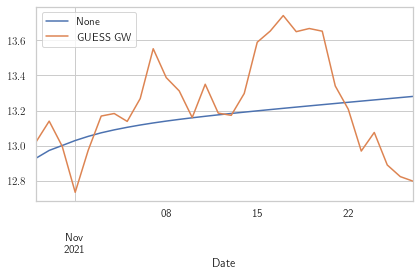

In [63]:
pred.plot(legend=True)
test['GUESS GW'].plot(legend=True)

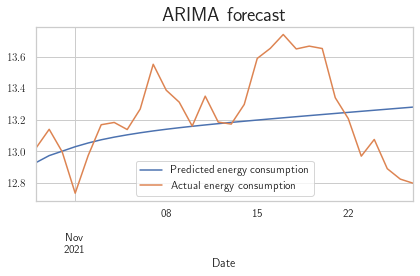

In [69]:
pred.plot(legend=True)
test['GUESS GW'].plot(legend=True)
plt.legend(['Predicted energy consumption', 'Actual energy consumption'])
plt.title('ARIMA forecast')
plt.savefig('ARIMA_forecast.png', dpi=400, transparent=True)

<AxesSubplot:xlabel='Date'>

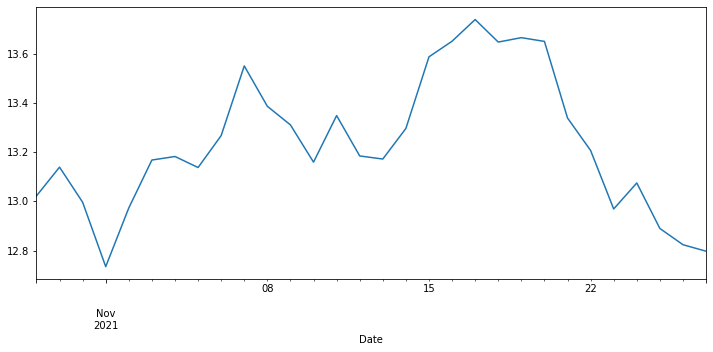

In [89]:
comparison = df.reset_index()
comparison = comparison[comparison["Date"] > "2021-10-28"]
comparison = comparison.set_index("Date")
comparison["GUESS GW"].plot(figsize=(12,5))

In [62]:
test['GUESS GW'].mean()

13.236316957554164

In [64]:
rmse=sqrt(mean_squared_error(pred,test['GUESS GW']))
print(rmse)

0.28122567567638734


In [66]:
model2=ARIMA(df['GUESS GW'],order=(5,1,0))
model2=model2.fit()
df.tail()

,Timestamp,MAX GW,MIN GW,GUESS GW,annualised consumption MAX TWh,annualised consumption MIN TWh,annualised consumption GUESS TWh
Date,,,,,,,
2021-11-23,1637625600,48.617960,4.709599,12.969188,426.185037,41.284341,113.687902
2021-11-24,1637712000,49.014837,4.748044,13.075058,429.664059,41.621352,114.615956
2021-11-25,1637798400,48.320291,4.680764,12.889783,423.575674,41.031573,112.991836
2021-11-26,1637884800,48.072227,4.656734,12.823610,421.401140,40.820927,112.411763
2021-11-27,1637971200,47.973019,4.647123,12.797145,420.531481,40.736684,112.179775


In [67]:
index_future_dates=pd.date_range(start='2021-11-10',end='2021-12-10')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2021-11-10    12.776287
2021-11-11    12.753498
2021-11-12    12.731278
2021-11-13    12.720087
2021-11-14    12.713594
2021-11-15    12.709245
2021-11-16    12.706419
2021-11-17    12.705653
2021-11-18    12.706670
2021-11-19    12.708815
2021-11-20    12.711765
2021-11-21    12.715402
2021-11-22    12.719629
2021-11-23    12.724308
2021-11-24    12.729323
2021-11-25    12.734604
2021-11-26    12.740099
2021-11-27    12.745764
2021-11-28    12.751561
2021-11-29    12.757461
2021-11-30    12.763442
2021-12-01    12.769488
2021-12-02    12.775583
2021-12-03    12.781719
2021-12-04    12.787885
2021-12-05    12.794076
2021-12-06    12.800287
2021-12-07    12.806512
2021-12-08    12.812749
2021-12-09    12.818996
2021-12-10    12.825250
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

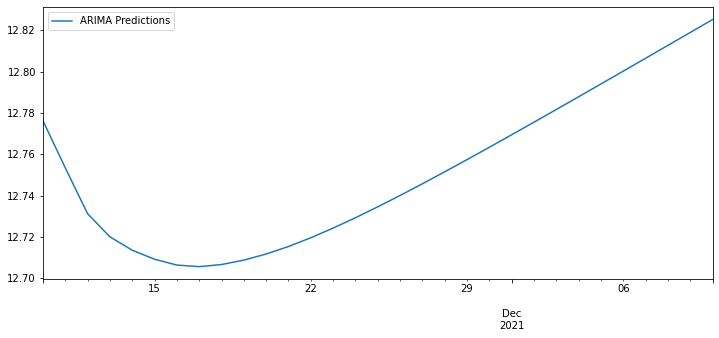

In [68]:
pred.plot(figsize=(12,5),legend=True)

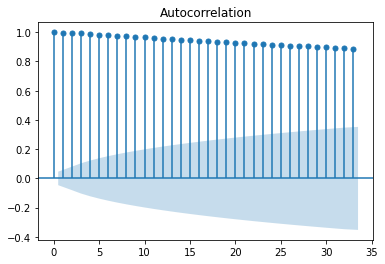

In [121]:
# create acf plot
plot_acf(df["GUESS GW"])
pyplot.show()

In [108]:
data_train = train["GUESS GW"]
garch = arch_model(data_train, mean='Zero', vol='GARCH', p=15, q=15)
garch_fit = garch.fit()

Iteration:      1,   Func. Count:     33,   Neg. LLF: 5380.774979409223
Iteration:      2,   Func. Count:     65,   Neg. LLF: 5381.148191247085
Iteration:      3,   Func. Count:     98,   Neg. LLF: 5380.764775804555
Iteration:      4,   Func. Count:    130,   Neg. LLF: 5380.764774121089
Iteration:      5,   Func. Count:    161,   Neg. LLF: 5380.764774110922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5380.764774121089
            Iterations: 5
            Function evaluations: 161
            Gradient evaluations: 5


In [122]:
# forecast the test set
yhat = garch_fit.forecast(horizon=30)
# plot the actual variance
# ...

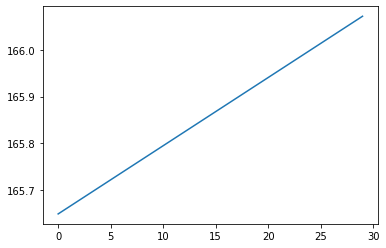

In [118]:
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()